# Sell apartment overview

In this notebook I will transform available data and visualize it for some basic overview of data shape. 
This will be first insight for further house market analysis and prediction model for prices.  


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(16,9)})
sns.set_context('talk')
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 2000)

df = pd.read_csv('data/sell_wroclaw_total_total_20210411_07_00_14.csv')

In [2]:
df.describe().round(2)

,area,year,market,floor_count
count,17688.00,17688.00,17688.00,17688.00
mean,57.28,1706.99,0.68,3.78
std,22.87,746.10,0.47,3.21
min,0.00,0.00,0.00,0.00
25%,42.51,1980.00,0.00,2.00
50%,53.70,2020.00,1.00,4.00
75%,66.28,2021.00,1.00,5.00
max,750.00,20201.00,1.00,52.00


In [3]:
df.isnull().values.any()

True

Dataframe is not so well prepared right now - there are only three numeric columns and some Nan values, so it needs to be edited in next steps for better data presentation.

In [4]:
df.isnull().describe()

,id,price,price_m,area,room,year,loc,url,offer,seller,addons,market,floor,floor_count
count,17688,17688,17688,17688,17688,17688,17688,17688,17688,17688,17688,17688,17688,17688
unique,1,1,1,1,1,1,1,1,1,1,2,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,17688,17688,17688,17688,17688,17688,17688,17688,17688,17688,16405,17688,17688,17688


Actually there are some Nan values in `addons` column, which mean there are offers without any additional information checked. Replace them with `0`

In [5]:
df['addons'].fillna(0, inplace=True)

## Transform columns for better data presentation

Reduce offers without given price

In [6]:
df = df[df['price'] != 'ask for price']
df = df[df['price_m'] != 'ask for price']

Transform remain prices from `object` to `int` value

In [7]:
df['price'] = df['price'].astype(int)

Segmentate `price_m`, so each price per meter will be rounded to 500 zł for each segment. 

In [8]:
df['price_m'] = df['price_m'].astype(int).apply(lambda x: int(x/500)*500)

Segmentate `area`, so each area value will be rounded to 2 meters squared for each segment.

In [9]:
df['area'] = df['area'].apply(lambda x: int(x/2)*2)

Reduce number of `room` entry categories. Leave value for 1-4 rooms and gather 5 and more rooms as one category.

In [10]:
df['room'] = df['room'].apply(lambda x: x if x in ('1','2','3','4') else '5 and more')

Apply formula for `year` to count as decades all offers with year of construction less than 2020 and count 'year by year' for 2020+. It will provide better visualisation of data as singificant amount of offers are from primary market.

In [11]:
df['year'] = df['year'].apply(lambda x: x if x >= 2020 else int(x/10)*10)

Reduce offers without year of construction and some exclusive high price offers to reduce extremum.

In [12]:
df = df[df['year'] != 0]
df = df[df['price_m'] < 18000]
df = df[df['area'] < 250]

In [13]:
df.describe().round(2)

,price,price_m,area,year,market,floor_count
count,14274.00,14274.00,14274.00,14274.00,14274.00,14274.00
mean,500254.56,8701.17,55.93,2008.79,0.68,3.78
std,217326.91,2099.79,20.72,218.04,0.47,2.87
min,128445.00,2000.00,12.00,20.00,0.00,0.00
25%,374709.25,7000.00,42.00,2010.00,0.00,2.00
50%,449000.00,8500.00,52.00,2020.00,1.00,4.00
75%,559000.00,9500.00,66.00,2021.00,1.00,5.00
max,2500000.00,17500.00,230.00,20201.00,1.00,51.00


This is much more convenient and reasonable dataset, reduced from uncomplete data and with standarized data types. There will be more transformation later, but for now we can view basic info counts.

### Offer count in relation to Area

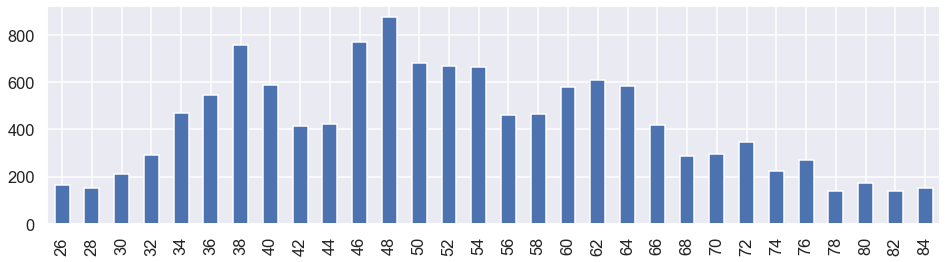

In [14]:
sns.color_palette("dark")
df['area'].value_counts().head(30).sort_index().plot.bar(stacked=True, figsize=(16,4))

### Offer count in relation to Room count

Text(0.5, 0, 'Offer count')

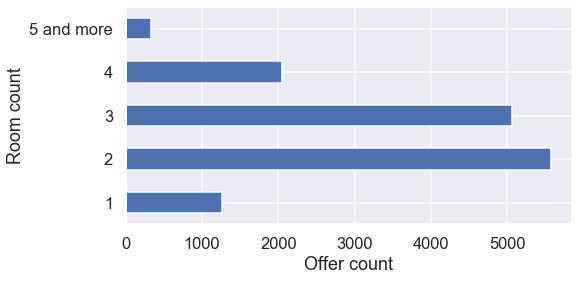

In [15]:
df['room'].value_counts().sort_index().head(5).plot(kind='barh', figsize=(8,4))
plt.ylabel('Room count')
plt.xlabel('Offer count')

### Offer count presented as Room count in relation to Area

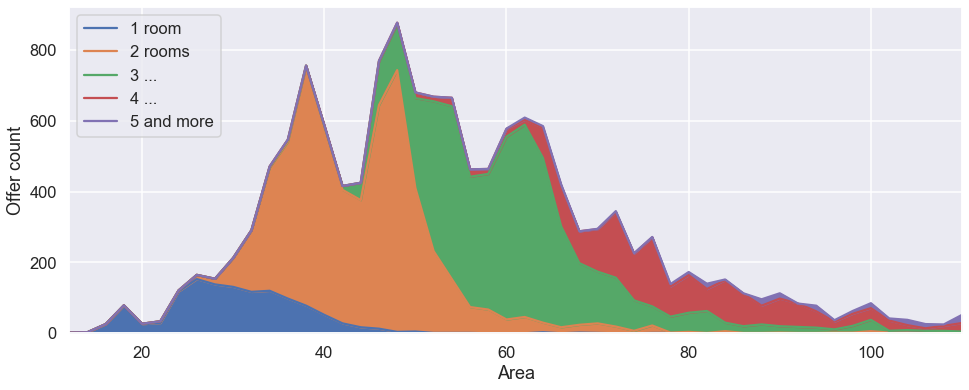

In [16]:
df[['area', 'room']].pivot_table(index=df['area'], columns='room', aggfunc='count').head(50).plot(kind='area', stacked=True, figsize=[16,6])
plt.ylabel('Offer count')
plt.xlabel('Area')
plt.legend(['1 room','2 rooms','3 ...','4 ...','5 and more'], loc='upper left')

It is pretty clear that most offers oscilate around 8k per meter, but there is also visible trend with 1 room (kawalerka), where most offer oscilate around 9-10k per meter squared and two rooms 8-9k per meter.

### Offer count in relation to Year of construction

Data is categorized in decades until 2020 year which has offer count for single year.

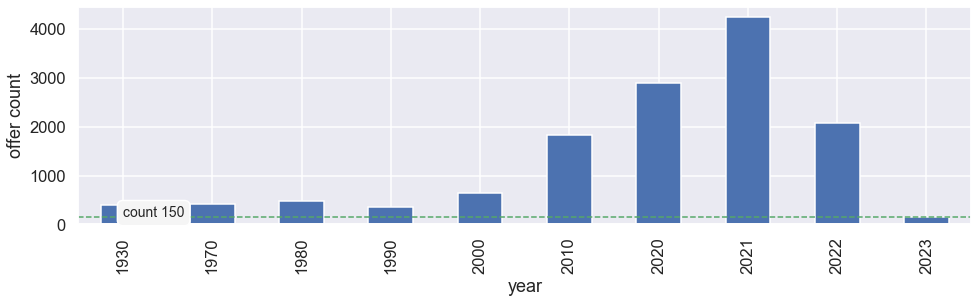

In [17]:
df[df['year'] != 0]['year'].value_counts().head(10).sort_index().plot(kind='bar', figsize=(16,4))
plt.ylabel('offer count')
plt.xlabel('year')
plt.axhline(y=150, color='g', linestyle='--', linewidth=1.5)
plt.text(x=0, y=150, s="count 150", fontsize=14, bbox=dict(facecolor='whitesmoke', boxstyle="round, pad=0.4"));


### Offer count in relation to Seller

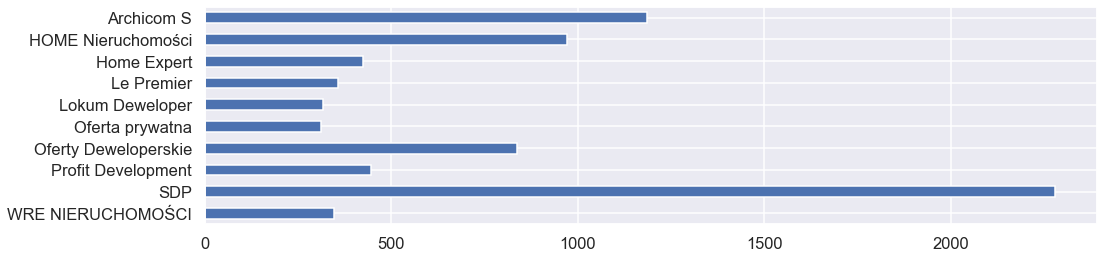

In [18]:
df['seller'].value_counts().head(10).sort_index(ascending=False).plot(kind='barh', figsize=(16,4))

### Offer count in relation to Market

`0` means this is aftermarket offer nad `1` means this is primary offer.

Text(0, 0.5, 'market')

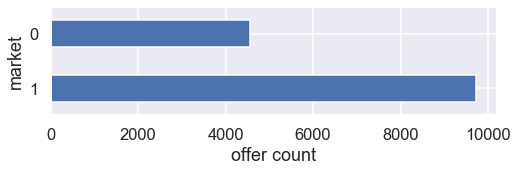

In [19]:
df['market'].value_counts().plot(kind='barh', figsize=(8,2))
plt.xlabel('offer count')
plt.ylabel('market')

### Offer count in relation to Floor of apartment

Text(0, 0.5, 'floor')

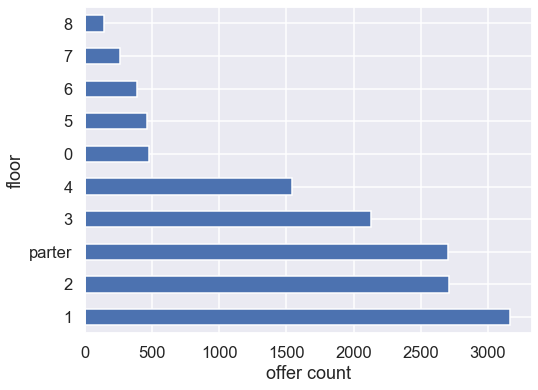

In [20]:
df['floor'].value_counts().head(10).plot(kind='barh', figsize=(8,6))
plt.xlabel('offer count')
plt.ylabel('floor')

### Offer count in relation to Floor count of building

Text(0, 0.5, 'floor count')

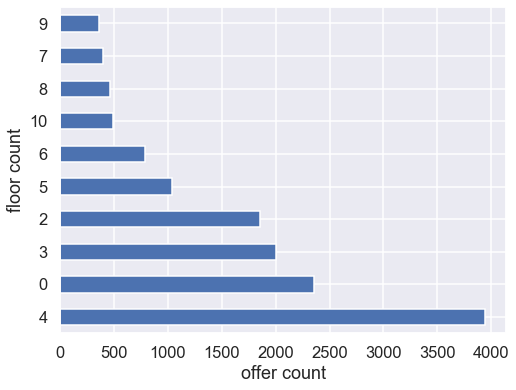

In [21]:
df['floor_count'].value_counts().head(10).plot(kind='barh', figsize=(8,6))
plt.xlabel('offer count')
plt.ylabel('floor count')

## Create new column matrix for additional information 

Create columns with names for additional real estate features, then apply value `1` if offer has the feature.

In [22]:
cols = ['balkon', 'garaż/miejsce', 'dwupoziomowe', 'teren zamknięty', 'ogródek', 'taras', 'piwnica', 'kuchnia', 'winda']

def create_columns(cols):
    for i in range(len(cols)):
        df.loc[df['addons'].str.contains(cols[i], na=False), cols[i]] = 1
    df.fillna(0, inplace=True)

create_columns(cols)
df[cols].describe().head(2)

,balkon,garaż/miejsce,dwupoziomowe,teren zamknięty,ogródek,taras,piwnica,kuchnia,winda
count,14274.000000,14274.000000,14274.000000,14274.000000,14274.000000,14274.000000,14274.000000,14274.000000,14274.000000
mean,0.573911,0.566134,0.021718,0.084699,0.093457,0.112372,0.184251,0.196161,0.544627


The `mean` values actually contains percentage share of market for each additional feature. It just need to be multiplied by 100%. It is possible due to use of binary description `0 - not exist, 1 - exist`.
Below you can find visual presentation of features.

Text(0.5, 1.0, 'Apartment features share')

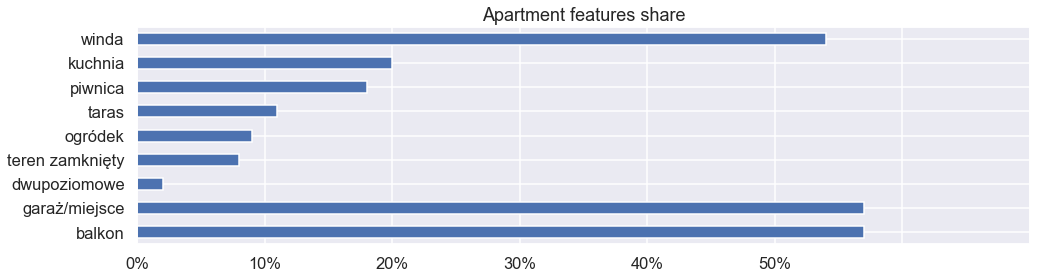

In [23]:
plt.gca().set_xticklabels(['{:.0f}%'.format(x*50) for x in plt.gca().get_xticks()])
(df[cols].mean().round(2) * 100).plot(kind='barh', figsize=(16,4), color='b', xlim=(0,70))
plt.title('Apartment features share')

And the same list of features, but only for <b>aftemarket </b>offers


Text(0.5, 1.0, 'Aftermarket apartment features share')

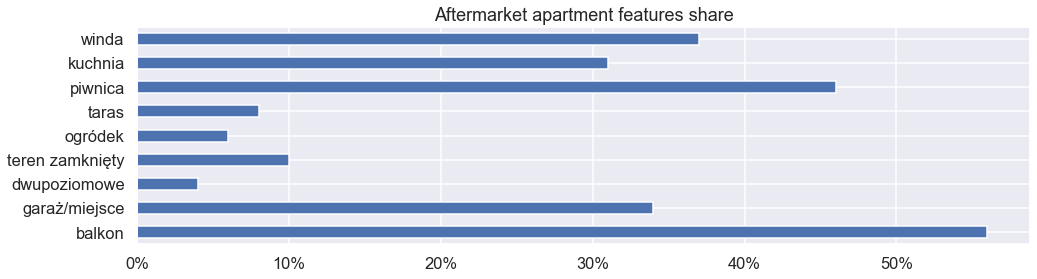

In [24]:
plt.gca().set_xticklabels(['{:.0f}%'.format(x*50) for x in plt.gca().get_xticks()]) 
(df[df['market'] == 0][cols].mean().round(2) * 100).plot(kind='barh', figsize=(16,4), color='b')
plt.title('Aftermarket apartment features share')

Text(0.5, 1.0, 'Primary market apartment features share')

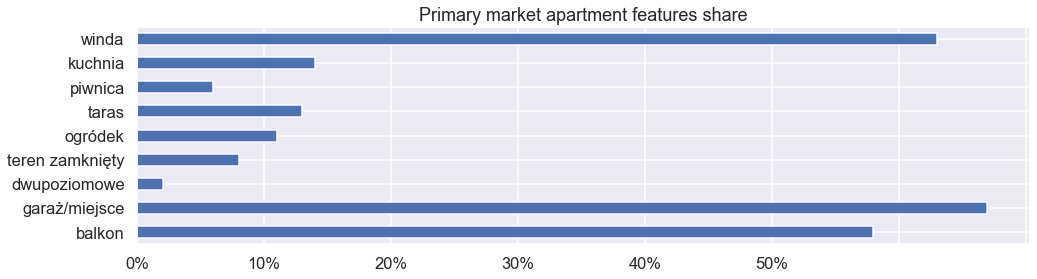

In [25]:
plt.gca().set_xticklabels(['{:.0f}%'.format(x*50) for x in plt.gca().get_xticks()]) 
(df[df['market'] == 1][cols].mean().round(2) * 100).plot(kind='barh', figsize=(16,4), color='b')
plt.title('Primary market apartment features share')

This is very interesting that `garaż/miejsce` is included in 70% from primary market offer. It is very common experience that parking place is addictionally priced and obligatory to buy with apartment. Prices differ from 20-50k, so it should be expected that almost 70% of primary market have this hidden cost included and final price is much bigger.


## Price per meter trends

### Offer count presented as Room count in relation to Price per meter

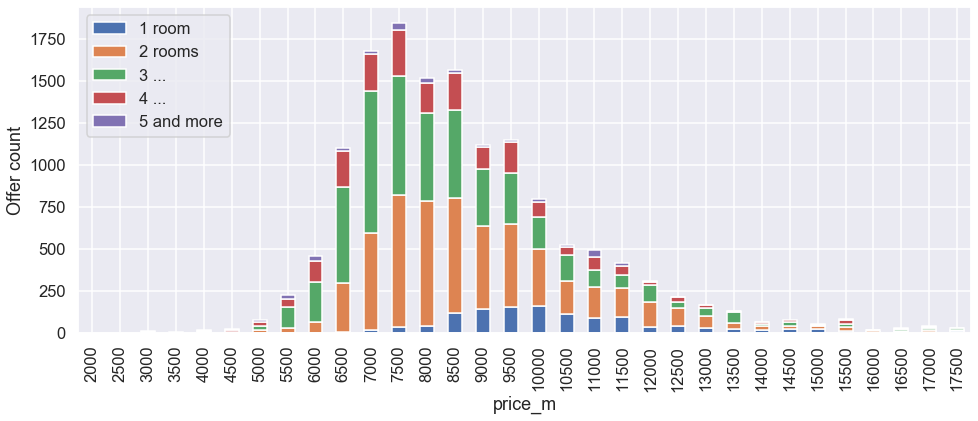

In [26]:
df[['price_m', 'room']].pivot_table(index='price_m', columns='room', aggfunc=len).plot(kind='bar', stacked=True, figsize=[16,6], xlim=(4000,15000))
plt.ylabel('Offer count')
plt.xlabel('price_m')
plt.legend(['1 room','2 rooms','3 ...','4 ...','5 and more'], loc='upper left')

### Offer count presented as building's Floor count share in relation to Price per meter

Text(0.5, 0, 'floor count')

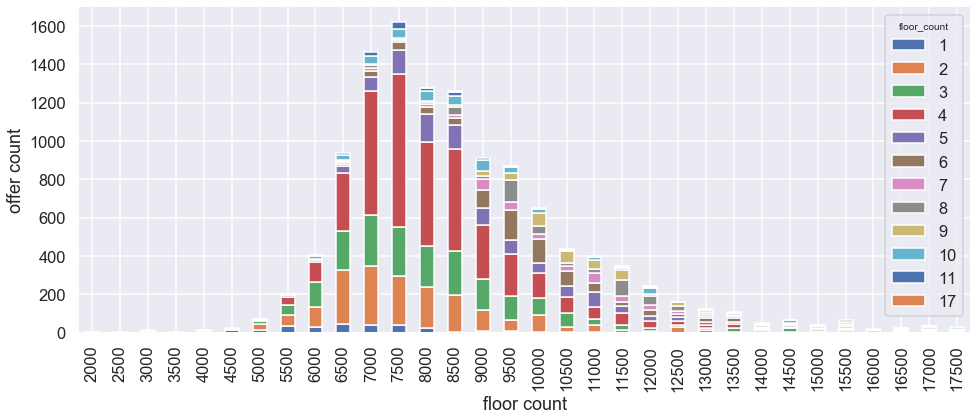

In [27]:
index = df[df['floor_count'] != 0]['floor_count'].value_counts()[0:12].index
df[['price_m', 'floor_count']][df['floor_count'].isin(index)].pivot_table(index='price_m', columns='floor_count', aggfunc=len).plot(kind='bar', stacked=True, figsize=[16,6], xlim=(4000,15000))
plt.ylabel('offer count')
plt.xlabel('floor count')

### Offer count presented as apartment's Floor share in relation to Price per meter

Text(0.5, 0, 'floor')

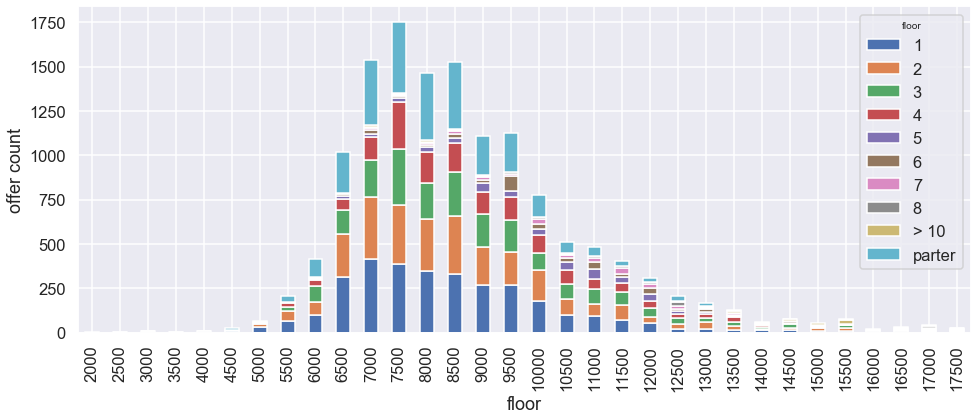

In [28]:
index = df[df['floor'] != '0']['floor'].value_counts()[0:10].index
df[['price_m', 'floor']][df['floor'].isin(index)].pivot_table(index='price_m', columns='floor', aggfunc=len).plot(kind='bar', stacked=True, figsize=[16,6], xlim=(4000,15000))
plt.ylabel('offer count')
plt.xlabel('floor')

In [29]:
view = ['id','price','price_m','area','room','year','loc','url','winda', 'floor', 'floor_count']

In [30]:
df.query('floor_count==18')[view].head(10)

,id,price,price_m,area,room,year,loc,url,winda,floor,floor_count
1889,ID4aL9N,799000,17000,46,2,2010,"Wrocław, dolnośląskie",https://www.otodom.pl/pl/oferta/ID4aL9N,1.0,8,18
1960,ID4alzP,610000,9000,64,3,2010,"Wrocław, dolnośląskie",https://www.otodom.pl/pl/oferta/ID4alzP,1.0,4,18
2305,ID45gPs,799000,17000,46,2,2010,"Wrocław, Stare Miasto",https://www.otodom.pl/pl/oferta/ID45gPs,1.0,8,18
2736,ID4avgq,1699000,16500,100,3,2010,"Wrocław, dolnośląskie",https://www.otodom.pl/pl/oferta/ID4avgq,1.0,> 10,18
5033,ID47tVP,820000,16000,48,2,2010,"Wrocław, Stare Miasto, Sikorskiego",https://www.otodom.pl/pl/oferta/ID47tVP,1.0,> 10,18
5408,ID45gOJ,1699000,16500,100,3,2010,"Wrocław, Stare Miasto",https://www.otodom.pl/pl/oferta/ID45gOJ,1.0,> 10,18
5424,ID45cO2,799000,17000,46,2,2010,"Wrocław, Stare Miasto, Szczepin",https://www.otodom.pl/pl/oferta/ID45cO2,0.0,8,18
5435,ID45anI,1699000,16500,100,4,2010,"Wrocław, Stare Miasto",https://www.otodom.pl/pl/oferta/ID45anI,1.0,> 10,18
6372,ID452FL,799000,17000,46,2,2010,"Wrocław, Stare Miasto, Szczepin, ul. gen. Wład...",https://www.otodom.pl/pl/oferta/ID452FL,1.0,8,18
6374,ID4571O,1699000,16500,100,3,2010,"Wrocław, Stare Miasto, Szczepin, ul. gen. Wład...",https://www.otodom.pl/pl/oferta/ID4571O,1.0,> 10,18


In [31]:
df.query('floor_count==0 & winda==1')[view]

,id,price,price_m,area,room,year,loc,url,winda,floor,floor_count
1,ID4acrQ,545000,10000,52,2,2010,"Wrocław, Fabryczna, Grabiszyn, ul. Mosiężna",https://www.otodom.pl/pl/oferta/ID4acrQ,1.0,1,0
255,ID4aGl3,549000,8500,62,3,1980,"Wrocław, Fabryczna, Gądów Mały, ul. Stefana Dr...",https://www.otodom.pl/pl/oferta/ID4aGl3,1.0,8,0
273,ID4aUAs,435000,7000,60,3,1980,"Wrocław, Fabryczna, Kozanów, ul. Dzielna",https://www.otodom.pl/pl/oferta/ID4aUAs,1.0,9,0
359,ID4aVMm,470000,11000,42,2,2010,"Wrocław, Śródmieście",https://www.otodom.pl/pl/oferta/ID4aVMm,1.0,5,0
382,ID48jqJ,196800,7500,24,1,2020,"Wrocław, Fabryczna, ul. Władysława Zarembowicza",https://www.otodom.pl/pl/oferta/ID48jqJ,1.0,4,0
...,...,...,...,...,...,...,...,...,...,...,...
17043,ID46KnA,426060,6500,62,3,2010,"Wrocław, Psie Pole, ul. Ubocze",https://www.otodom.pl/pl/oferta/ID46KnA,1.0,2,0
17046,ID46Knt,357285,7000,48,2,2010,"Wrocław, Psie Pole, ul. Ubocze",https://www.otodom.pl/pl/oferta/ID46Knt,1.0,parter,0
17107,ID46x3H,462442,11500,38,2,2010,"Wrocław, Śródmieście, ul. Mieszczańska",https://www.otodom.pl/pl/oferta/ID46x3H,1.0,4,0
17513,ID44YmB,265962,10500,24,1,2021,"Wrocław, Fabryczna, Jaworska 4",https://www.otodom.pl/pl/oferta/ID44YmB,1.0,3,0


## Search for private offers with a construction year before 1939 with balcon

In [32]:
df.query('year<1939 & year>0 & seller=="Oferta prywatna" & balkon==1')[view].sort_values(by='price', ascending='False')

,id,price,price_m,area,room,year,loc,url,winda,floor,floor_count
536,ID4aIYG,415000,16500,24,1,1850,"Wrocław, Stare Miasto, ul. Staromłyńska",https://www.otodom.pl/pl/oferta/ID4aIYG,1.0,1,5
487,ID48ybB,570000,8000,68,3,1930,"Wrocław, Fabryczna, Grabiszyn",https://www.otodom.pl/pl/oferta/ID48ybB,0.0,2,5
822,ID4aqxH,579000,7000,80,3,1930,"Karłowice, Wrocław, dolnośląskie",https://www.otodom.pl/pl/oferta/ID4aqxH,0.0,parter,2
1874,ID4awz6,585000,6500,84,3,1920,"Wrocław, Śródmieście, ul. Stefana Żeromskiego 29",https://www.otodom.pl/pl/oferta/ID4awz6,0.0,3,4
869,ID4aQ53,660000,6500,98,5 and more,1930,"Wrocław, Śródmieście, Centrum, ul. Karola Marc...",https://www.otodom.pl/pl/oferta/ID4aQ53,0.0,2,3
2049,ID4aIN5,830000,8500,92,4,1930,"Wrocław, Krzyki, Borek, ul. Racławicka",https://www.otodom.pl/pl/oferta/ID4aIN5,0.0,1,2
